In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import seaborn as sns
sns.set()

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from automl import preprocessing, builder, metrics

In [4]:
train = pd.read_csv("./data/credit_risk_dataset.csv.zip", sep=",")

In [5]:
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [6]:
def check_missing(df):
    df_na = df.isnull().mean()
    return df_na[df_na > 0].to_dict()

check_missing(train)

{'person_emp_length': 0.027469997851508547,
 'loan_int_rate': 0.0956385623522912}

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [11]:
train.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,31686.000000,32581.000000,29465.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.789686,9589.371106,11.011695,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.142630,6322.086646,3.240459,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


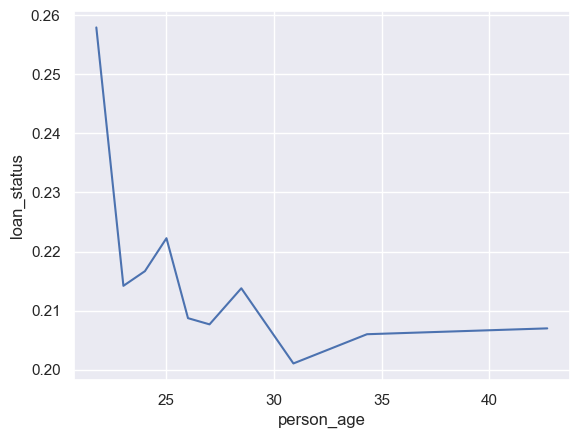

In [8]:
rp = metrics.rankplot(train, 'person_age', 'loan_status', show=True)

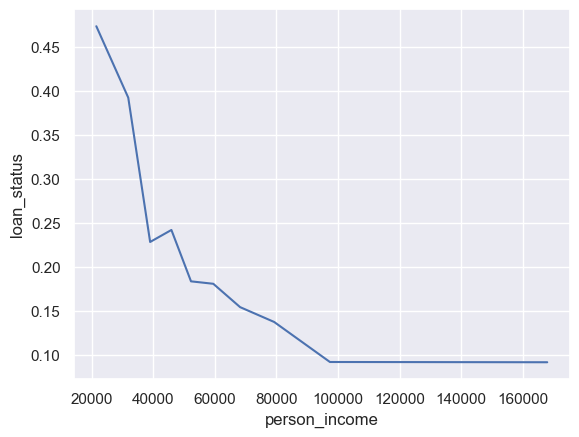

In [9]:
rp = metrics.rankplot(train, 'person_income', 'loan_status', show=True)

In [18]:
num_raw = train.columns[train.dtypes != object].tolist()
cat_raw = train.columns[train.dtypes == object].tolist()
print(num_raw)
print(cat_raw)

['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_status', 'loan_percent_income', 'cb_person_cred_hist_length', 'bucket']
['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']


In [19]:
for x in ['loan_status']:
    num_raw.remove(x)

num_vars = num_raw[:]
cat_vars = cat_raw[:]

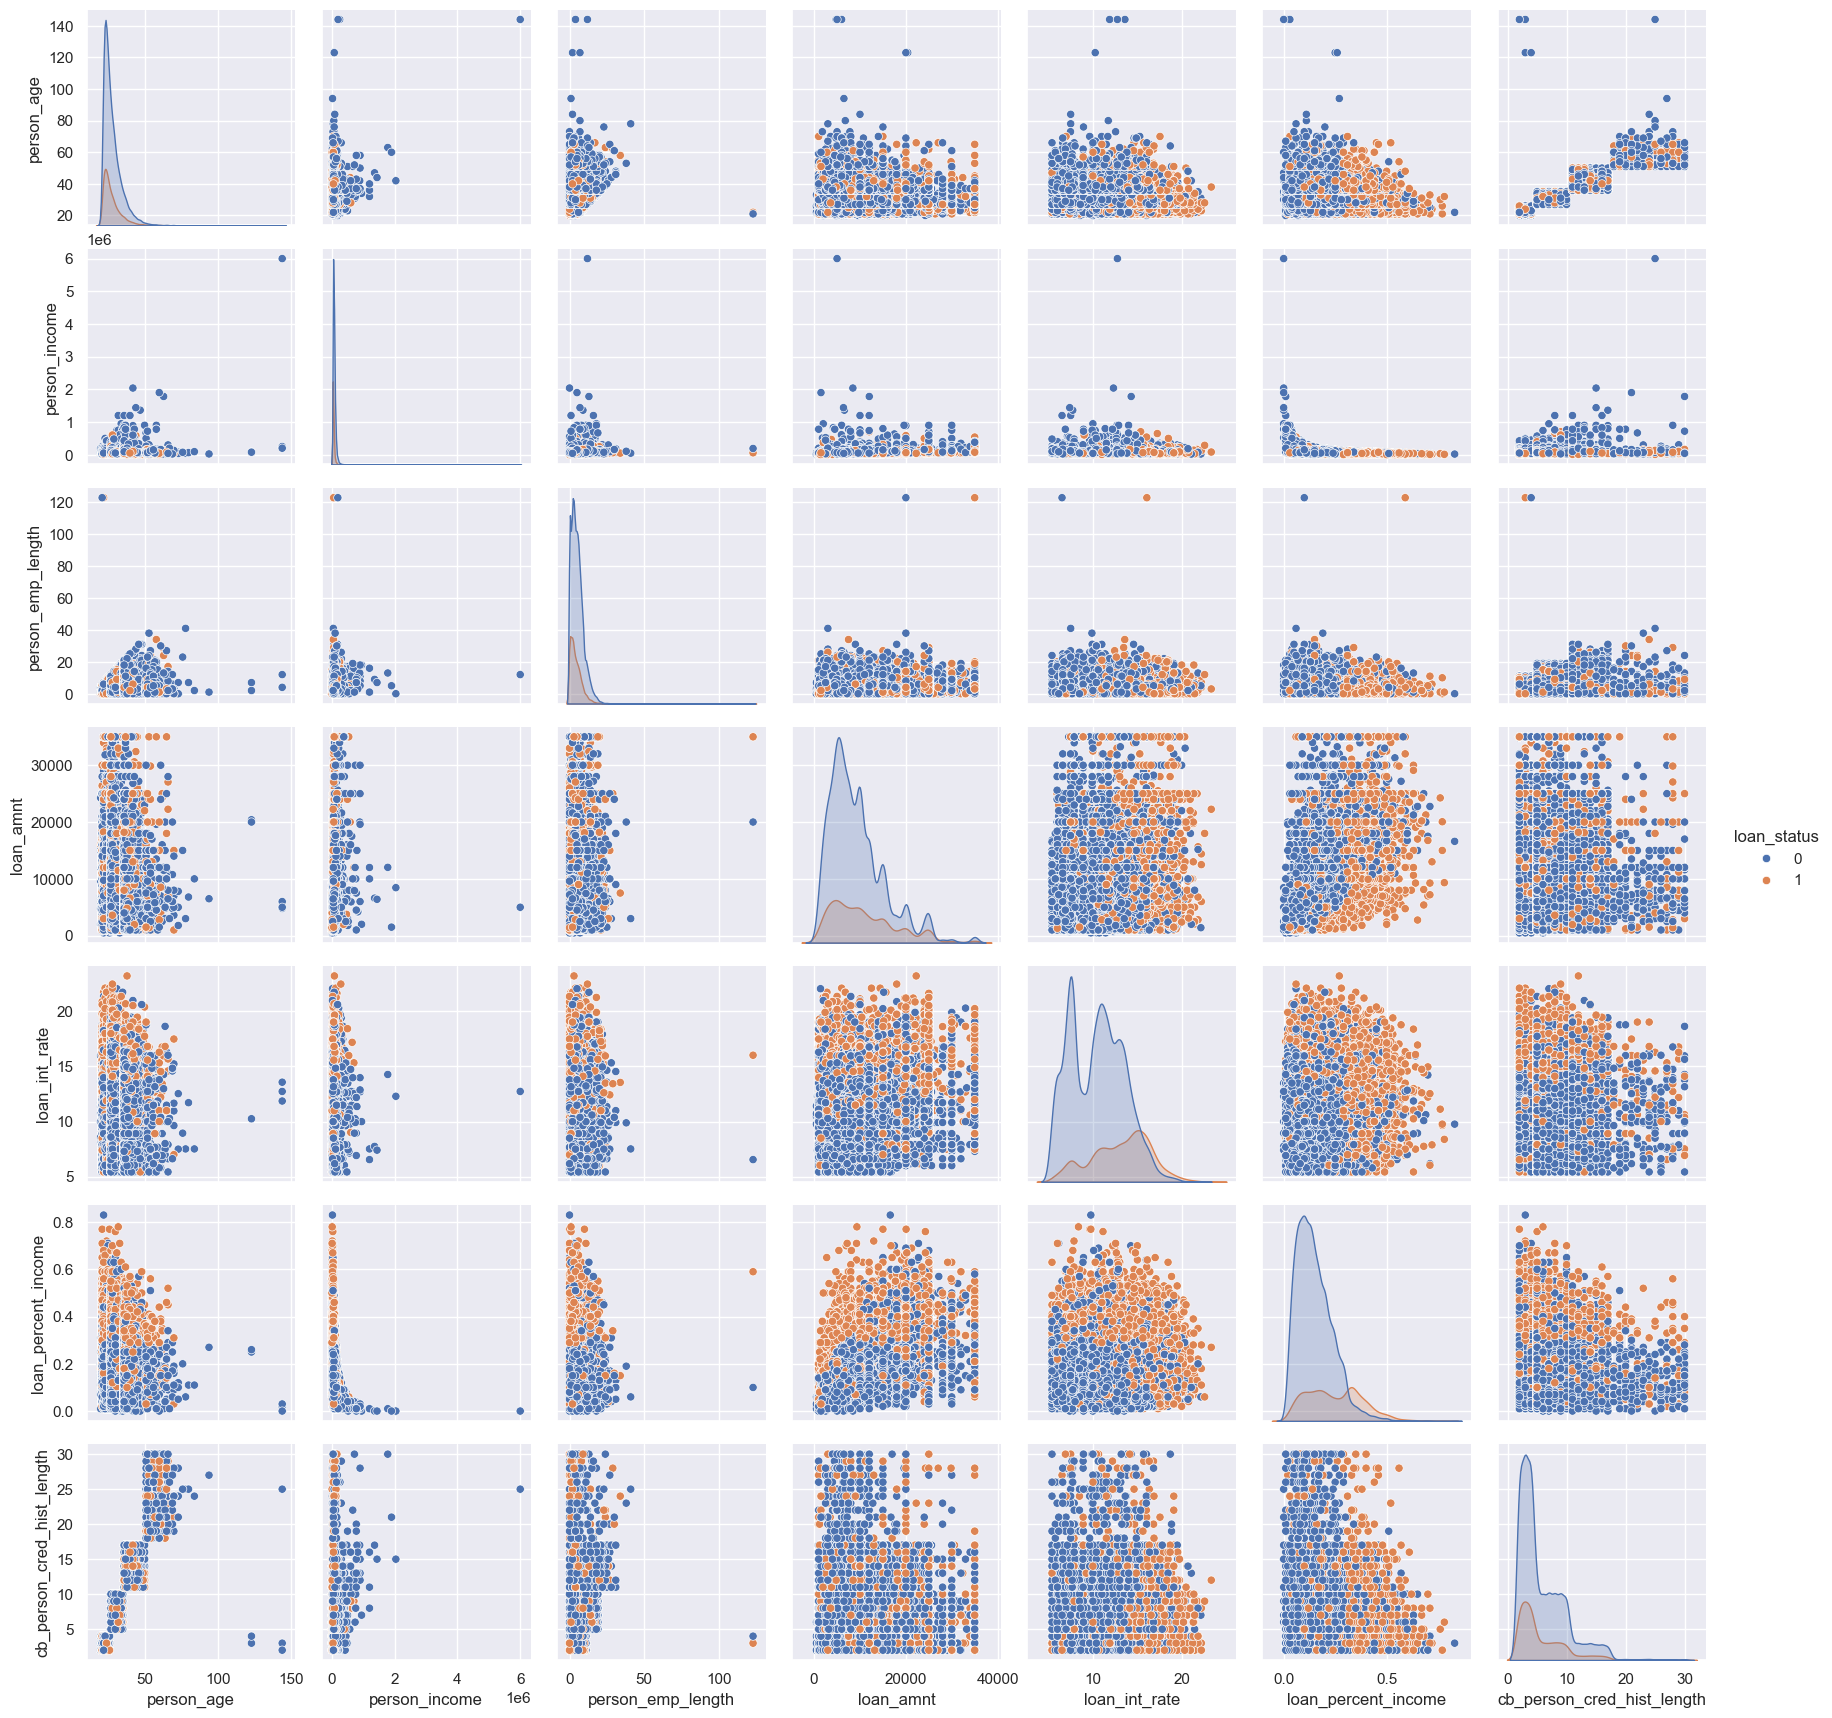

In [14]:
sns.pairplot(train, hue='loan_status')

In [21]:
dev, oos = preprocessing.split_sample(train)
print(dev.shape, oos.shape, train.shape)

(22873, 13) (9708, 13) (32581, 13)


In [22]:
imp = preprocessing.Imputation(num_vars, cat_vars, num_strategy='mean', cat_strategy='UNK')
imp.fit(dev)
for ds in [dev, oos]:
    imp.transform(ds)
    
le = preprocessing.LabelEncoder(ordinal=True, unknown='UNK', default=999999)
le.fit(dev, cat_vars, 'loan_status')
for ds in [dev, oos]:
    le.transform(ds)

In [24]:
cat_vars_label = [x + '_label' for x in cat_vars]
feats = num_vars + cat_vars_label

In [25]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=20, n_jobs=-1)
rf = builder.build_model(rf, dev, oos, feats, 'loan_status')

0.979382470119522
0.8502066552025824


In [26]:
params = {'objective':'binary', 'random_state':100, 'n_jobs':-1,
          'n_estimators':1000, 
          'max_depth':-1, 
          'learning_rate':0.02,
          'num_leaves':40,
          'min_child_samples':50,
          'subsample':0.9,
          'reg_alpha':0.5,
          'reg_lambda':0.5}

gbm = lgb.LGBMClassifier(**params)
gbm = builder.build_model(gbm, dev, oos, feats, target='loan_status')

[LightGBM] [Info] Number of positive: 5020, number of negative: 17853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 922
[LightGBM] [Info] Number of data points in the train set: 22873, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.219473 -> initscore=-1.268742
[LightGBM] [Info] Start training from score -1.268742
0.9009090451614257
0.8639873140857393


In [27]:
metrics.lift_table(oos['loan_status'].values, oos['score'].values, weight=None, n_buckets=10)

,Quantile,Count,Units,Rate,Unit %,Value %
0,0.1,971.0,937.0,0.964985,0.053851,0.053851
1,0.2,1942.0,1561.0,0.803811,0.089713,0.089713
2,0.3,2913.0,1642.0,0.563680,0.094368,0.094368
3,0.4,3884.0,1711.0,0.440525,0.098333,0.098333
4,0.5,4855.0,1759.0,0.362307,0.101092,0.101092
5,0.6,5826.0,1812.0,0.311020,0.104138,0.104138
6,0.7,6797.0,1898.0,0.279241,0.109080,0.109080
7,0.8,7768.0,1971.0,0.253733,0.113276,0.113276
8,0.9,8739.0,2021.0,0.231262,0.116149,0.116149
9,1.0,9708.0,2088.0,0.215080,0.120000,0.120000
